## This notebook contains solutions to exercises 1, 2, 3, 10, 13 in Data analysis recipies: Fitting a model to data by David Hogg, Jo Bovy, and Dustin Lang.

In [5]:
# general imports for all coming exercises
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial
from matplotlib.patches import Ellipse


# Types
from typing import Callable
Matrix = type[np.ndarray]
Vector = type[np.ndarray]
Function = Callable[[Vector], Vector]

# Exercise 1: 
Use the standard linear algebra from Section 1. to fit the straight line $y = mx + b$ to the $x$, $y$, and $sigma_y$ values provided in the file `hogg-table1.txt`. We ignore the first four data points in the table.

In [6]:

TABLE_FILE = Path("data/hogg-table1.txt")
table = np.loadtxt(TABLE_FILE, usecols=(1, 2, 3, 4, 5), unpack=True)


We start by arranging the data in the table in to the vectors/matrices:
\begin{align*}
    \boldsymbol{Y} &= \begin{bmatrix}
        y_1 \\
        y_2 \\
        \dots \\ 
        y_N
    \end{bmatrix}, \\
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
    \dots & \dots\\ 
        1 & x_N
    \end{bmatrix}, \\
        \boldsymbol{C} &= \begin{bmatrix}
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 &  \sigma^2_{y_2} & \dots & 0 \\
        \dots & \dots & \dots & \dots & \\
        0 & 0 & \dots & \sigma^2_{y_N} \\
    \end{bmatrix}
\end{align*}

In [7]:
x, y, sigma_y = table[:, 5:][:3] # columns for x, y, and sigma_y

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y

We can then solve the normal equations:

\begin{align*}
    \begin{bmatrix}
        b \\ m
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}

In [8]:
def solve_normal_equations(A: Matrix, C: Matrix, Y: Vector) -> Vector:
    """Solves the equation X = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y]."""
    C_inv = np.linalg.inv(C)
    sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
    return sigma_inv @ (A.T @ C_inv @ Y)
    

In [9]:
b, m = solve_normal_equations(A, C, Y)
b, m

(34.845941313398725, 2.2325362169534166)

To get the uncertianties $\sigma_b$ and $\sigma_m$ we need to take the diagonal of the covariance matrix 
\begin{equation*}
\begin{bmatrix}
\sigma_b \\ 
\sigma_m
\end{bmatrix} = \mathrm{diag}\left( 
    \begin{bmatrix}
    \sigma_b^2 & \sigma_{mb}\\
    \sigma_{mb} & \sigma_m^2
    \end{bmatrix}
 \right)
\end{equation*},
where
\begin{equation*}
    \begin{bmatrix}
    \sigma_b^2 & \sigma_{mb}\\
    \sigma_{mb} & \sigma_m^2
    \end{bmatrix} = 
    \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1}
\end{equation*}
is the covariance matrix

In [10]:
def get_sigma_X(A: Matrix, C: Matrix) -> Vector:
    """Computes the uncertianty of the variables fit."""
    C_inv = np.linalg.inv(C)
    sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
    return np.sqrt(sigma_inv.diagonal())

In [11]:
sigma_b, sigma_m = get_sigma_X(A, C)
sigma_b, sigma_m

(18.42264040708828, 0.11031991507180255)

We plot the data and the best fit line $y = mx + b$ along with the uncertianties in $m$ and $b$:

In [12]:
def evaluate_linear_model(x: Vector, b: float, m: float) -> Vector:
    """Evaluate the linear model in excercise 1."""
    return m * x + b

Text(0, 0.5, '$y$')

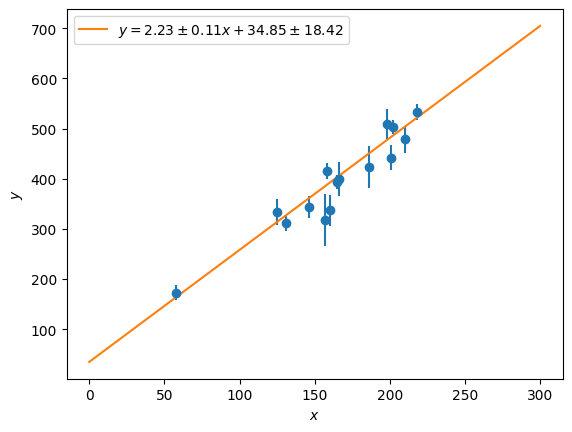

In [13]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_linear_model(x_new, b, m)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = {{{m:.2f}}} \pm {{{sigma_m:.2f}}}x + {b:.2f} \pm {{{sigma_b:.2f}}}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

## Exercise 2:

We repeat the above calculating but for all the data points in the original table

In [14]:
x, y, sigma_y = table[:3]
A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y

b, m = solve_normal_equations(A, C, Y)
b, m

(213.2734919759614, 1.0767475241683258)

In [15]:
sigma_b, sigma_m = get_sigma_X(A, C)
sigma_b, sigma_m

(14.39403310716221, 0.0774067831657561)

Text(0, 0.5, '$y$')

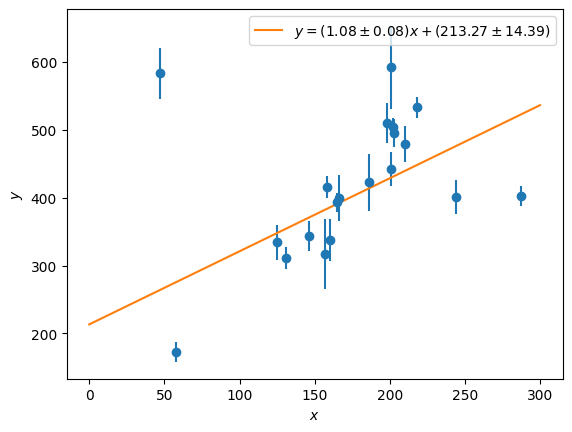

In [16]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_linear_model(x_new, b, m)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = ({{{m:.2f}}} \pm {{{sigma_m:.2f}}})x + ({b:.2f} \pm {{{sigma_b:.2f}}})$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

The new data points are some pretty big outliers which result in half as big of a slope. 

## Exercise 3:
We will now repeat the fit in exercise one but with a quadratic equation on the form $g(x) = q x^2 + m x + b$

In [17]:
def evaluate_quadratic_model(x: Vector, q: float, m: float, b: float) -> Vector:
    """Evaluate the quadratic model in exercise 3."""
    return q * x**2 + m * x + b

We can solve for $q$, $m$, and $b$ using the same method as before by adding another column to the matrix $\boldsymbol{A}$ which contains the $x^2$ values:

\begin{align}
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 & x_1^2 \\
        1 & x_2 & x_2^2 \\
         & \dots &  \\ 
        1 & x_N & x_N^2
    \end{bmatrix}. \\
\end{align}

Solving the normal equations now give us an additional fit for $q$:

\begin{align*}
    \begin{bmatrix}
        b \\ m \\ q
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}

In [18]:
x, y, sigma_y = table[:, 5:][0:3]
A = np.vstack([np.ones(len(x)), x, x**2]).T
C = np.diag(sigma_y**2)
Y = y

b, m, q = solve_normal_equations(A, C, Y)
b, m, q

(72.57649611682064, 1.6045304764425055, 0.002254145076158398)

We then get the uncertianties like earlier:

In [19]:
sigma_b, sigma_m, sigma_q = get_sigma_X(A, C)
sigma_b, sigma_m, sigma_q

(38.956134622701214, 0.5818712155922691, 0.002050669814280644)

Text(0, 0.5, '$y$')

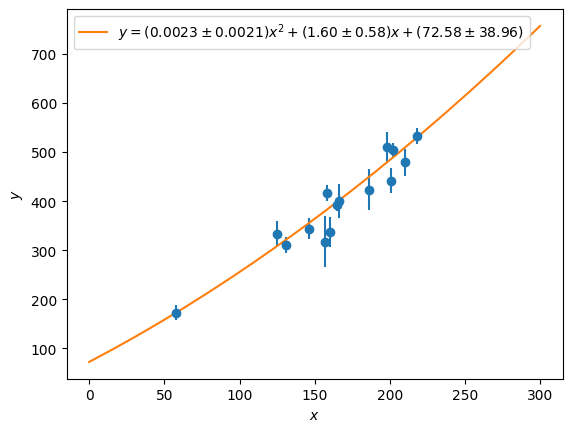

In [20]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_quadratic_model(x_new, q, m, b)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = ({{{q:.4f}}} \pm {{{sigma_q:.4f}}})x^2 + ({{{m:.2f}}} \pm {{{sigma_m:.2f}}})x + ({b:.2f} \pm {{{sigma_b:.2f}}})$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

## Exercise 10:
We want to compute the $\chi^2$, the total error squared scaled by the uncertianties, of the model in exercise 1. The chi^2 is given by
\begin{equation*}
    \chi^2 = \sum^N_{i=1} \frac{\left[ y_i - f(x_i) \right]^2}{\sigma^2_{y_i}}
\end{equation*},
which in linear algebra notation is
\begin{equation*}
\chi^2 \equiv \left[ \boldsymbol{Y} - \boldsymbol{A}\boldsymbol{X} \right]^T \boldsymbol{C}^{-1} \left[ \boldsymbol{Y} - \boldsymbol{A}\boldsymbol{X} \right]
\end{equation*}.

Below we implement the two definitions of the $\chi^2$:

In [21]:
def get_chi_squared(y: Vector, fn: Function, x: Vector, sigma_y: Vector) -> float:
    """Computes the chi squared value."""
    return np.sum((y - fn(x))**2 / sigma_y**2)

def get_chi_squared_linalg(A: Matrix, C: Matrix, Y: Vector, X: Vector) -> float:
    """Computes the chi squared value in matrix notation."""
    return (Y - A @ X).T @ np.linalg.inv(C) @ (Y - A @ X)

We make sure they return the same $\chi^2$ for the same model ($f(x)$ or $\boldsymbol{A}\boldsymbol{X}$):

In [22]:
x, y, sigma_y = table[:, 5:][0:3] # columns for x, y, and sigma_y as before in excerise 1

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y
b, m = solve_normal_equations(A, C, Y)

eval_model_ex1 = partial(evaluate_linear_model, b=b, m=m) # make a partial function with the fitted parameters for the linear model

chisq1 = get_chi_squared(y, eval_model_ex1, x, sigma_y)
chisq2 = get_chi_squared_linalg(A, C, Y, [b, m])
chisq1, chisq2

(18.582309526605396, 18.582309526605393)

We now do the same $\chi^2$ evaluation but for the model in exercise 2 where we have included the *bad* data points:

In [23]:
x, y, sigma_y = table[0:3] # columns for x, y, and sigma_y as before in excerise 1

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y
b, m = solve_normal_equations(A, C, Y)

eval_model_ex1 = partial(evaluate_linear_model, b=b, m=m) # make a partial function with the fitted parameters for the linear model

chisq1 = get_chi_squared(y, eval_model_ex1, x, sigma_y)
chisq2 = get_chi_squared_linalg(A, C, Y, [b, m])
chisq1, chisq2

(289.9637227819993, 289.9637227819993)

The $\chi^2$ in the second exercise is much larger than the one in exercise 1 as was expected from the inclusion of the data points that didnt appear to fit the linear model. 

## Exercise 13:
When solving for $b$ and $m$, we realize that not all values for $m$ are equally likely when fitting a line. Using the line given by $y = m x + b$ clums most possible lines close to $\pm \pi / 2$ as we can see below:

(0.0, 10.0)

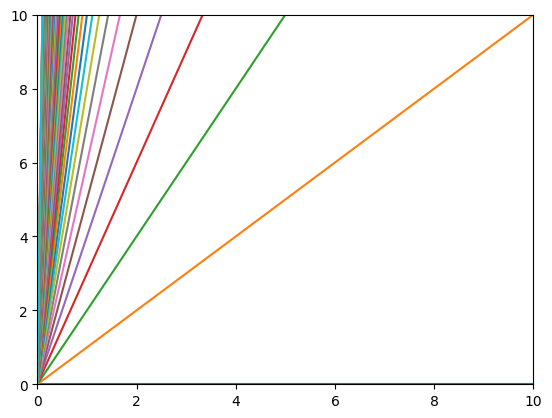

In [24]:
x = np.linspace(0, 10, 10)
ms = np.arange(0, 100)
b = 0
colors = plt.cm.viridis(np.linspace(0,1,len(ms)))
for m, color in zip(ms, colors):
    y = evaluate_linear_model(x, b, m)
    plt.plot(x, y)

plt.ylim(0, 10)
plt.xlim(0, 10)

This means that we are essentially using a non-uniform prior on our lines. If we instead use the angle $\theta = \arctan m$ 
and $b_{\bot} = b \cos \theta$ which is the perpendicular distance of the line from the origin, we see that we get a uniform distribution lines:

(0.0, 10.0)

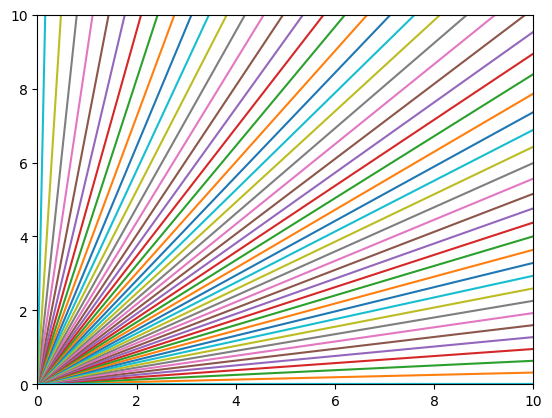

In [25]:
thetas = np.linspace(0, np.pi, 100)
x = np.linspace(0, 10, 10)
b = 0
for theta in thetas:
    y = evaluate_linear_model(x, b * np.cos(theta), np.tan(theta))
    plt.plot(x, y, label=f"{theta=}")
plt.ylim(0, 10)
plt.xlim(0, 10)

Meaning we should fit for $(\theta, b_{\bot})$ going forward.

What happens if we now include the uncertianties to the $x$ positions, $\sigma_x$? The full covariance metrix in this case becomes
\begin{equation*}
\boldsymbol{S}_i \equiv 
\begin{bmatrix} 
    \sigma^2_{xi} & \sigma_{xyi} \\
    \sigma_{xyi} & \sigma^2_{yi}\\
\end{bmatrix}
\end{equation*},
with $\sigma_{xyi} = \rho_{xyi}\sigma_{xi} \sigma{y_i}$ where $\rho_xy$ are extracted from the final column in the table. 

Similarely, probability of getting the measurement ($x_i$, $y_i$) is now given by a two-dimensional Gaussian instead on the form
\begin{equation*}
    p\left(x_i, y_i |\boldsymbol{S}_i, x, y\right) = \frac{1}{2\pi \sqrt{\det (\boldsymbol{S}_i)}} \exp \left( - \frac{1}{2} \left[\boldsymbol{Z}_i - \boldsymbol{Z} \right]^{\top} \boldsymbol{S}_i^{-1} \left[\boldsymbol{Z}_i - \boldsymbol{Z} \right]\right)
\end{equation*},

where we have made the column vectors

\begin{equation*}
    \boldsymbol{Z} = 
    \begin{bmatrix} 
    x \\ 
    y 
    \end{bmatrix}
\end{equation*}

\begin{equation*}
    \boldsymbol{Z}_i = 
    \begin{bmatrix} 
    x_i \\ 
    y_i 
    \end{bmatrix}
\end{equation*}

In [26]:
x, y, sigma_y, sigma_x, rho_xy = table[:, 5:]

Z = np.vstack([x, y]).T

S = np.zeros((len(x), 2, 2))
for idx, (sigma_xi, sigma_yi, rho_xyi) in enumerate(zip(sigma_x, sigma_y, rho_xy)):
    S[idx] = np.diag([sigma_xi**2, sigma_yi**2])
    sigma_xyi = sigma_xi * sigma_yi * rho_xyi
    S[idx, 0, 1] = S[idx, 1, 0] = sigma_xyi

Now how do we fit a line in this two-dimentional case? Instead of looking at the y-axis displacement, we now need a two-dimensional displacement. One way to do this is to describe the slope $m$ of a line in terms of an unit vector $\hat{\boldsymbol{v}}$ that is *orthogonal* to the that line
\begin{equation*}
    \hat{\boldsymbol{v}} = \frac{1}{\sqrt{1 + m^2}} 
    \begin{bmatrix} 
    -m \\
    1
    \end{bmatrix}
    =    
    \begin{bmatrix} 
    -\sin \theta \\
    \cos \theta
    \end{bmatrix}
\end{equation*},

The two-dimensional orthogonal displacement $\Delta_i$ of each data point ($x_i$, $y_i$) from the line is then given by
\begin{equation*}
    \Delta_i = \hat{\boldsymbol{v}}^{\top} \boldsymbol{Z}_i - b \cos \theta
\end{equation*}

Similiarely, the full two-dimensional covariance matrix $\boldsymbol{S}_i$ needs to be projected down to this new orthogonal to the line coordinate system:
\begin{equation*}
    \Sigma_i^2 = \hat{\boldsymbol{v}}^{\top} \boldsymbol{S}_i \hat{\boldsymbol{v}}
\end{equation*}

The new $\chi^2$ then becomes:
\begin{equation*}
    \chi^2 = \sum^N_{i=1} \frac{\Delta_i^2}{\Sigma^2_i}.
\end{equation*}

Im not sure wether or not there is an analytic maximum likelihood solution to this two-dimensional problem, but one way to maximize the likelihood is to perform a grid search on two parameters $\theta$ and $b_\bot$

Text(0, 0.5, '$y$')

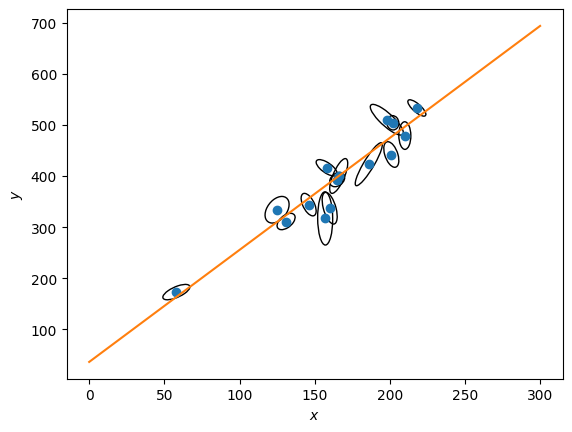

In [27]:
x, y, sigma_y, sigma_x, rho_xy = table[:, 5:]

theta_grid = np.linspace(0, np.pi, 100)
b_perp_grid = np.linspace(0, 100, 100)

chisqs: dict[tuple[int, int], float] = {}
for theta_idx, theta in enumerate(theta_grid):
    v_hat = np.array([-np.sin(theta), np.cos(theta)])
    for b_perp_idx, b_perp in enumerate(b_perp_grid):

        chisqs[theta_idx, b_perp_idx] = 0
        for x_i, y_i, sigma_y_i, sigma_x_i, rho_xy_i in zip(x, y, sigma_y, sigma_x, rho_xy):
            S = np.diag([sigma_x_i**2, sigma_y_i**2])
            sigma_xy = sigma_x_i * sigma_y_i * rho_xy_i
            S[0, 1] = S[1, 0] = sigma_xy
            Z = np.array([x_i, y_i])
            Delta_i = v_hat.T  @ Z - b_perp
            Sigma_sq = v_hat.T @ S @ v_hat
            chisqs[theta_idx, b_perp_idx] += Delta_i**2 / Sigma_sq


theta_idx, b_perp_idx = min(chisqs, key=chisqs.get)
theta = theta_grid[theta_idx]
b_perp = b_perp_grid[b_perp_idx]

# get the slope and intercept from the orthogonal model
m = np.tan(theta)
b = b_perp / np.cos(theta)

x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_linear_model(x_new, b, m)

fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(x_new, y_hat, label=rf"$y = {{{m:.2f}}}x + {b:.2f}$")

for xi, yi, sigma_xi, sigma_yi, rho_xyi in zip(x, y, sigma_x, sigma_y, rho_xy):
    a = sigma_xi**2
    c = sigma_yi**2
    b = rho_xyi * sigma_xi * sigma_yi

    lambda1 = (a + c)/2 + np.sqrt((a - c)**2/4 + b**2)
    lambda2 = (a + c)/2 - np.sqrt((a - c)**2/4 + b**2)

    theta = np.arctan2(lambda1 - a, b)
    ax.add_artist(Ellipse([xi, yi], 2*np.sqrt(lambda1), 2*np.sqrt(lambda2), angle=np.rad2deg(theta), fill=False))

plt.xlabel("$x$")
plt.ylabel("$y$")

